In [2]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [3]:
train_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data)
for fold in folds:
    foldpath = os.path.join(train_data, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
valid_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data)
for fold in folds:
    foldpath = os.path.join(valid_data, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)


In [5]:
test_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data)

for fold in folds:
    foldpath = os.path.join(test_data,fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [6]:
train_df, dummy_df = train_test_split(df,train_size=0.8,shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5,shuffle=True, random_state=42)

In [7]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(class_count, activation="softmax")
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,090 (12.62 MB)

 Trainable params: 3,309,090 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 15

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15


I0000 00:00:1731420368.190784      77 service.cc:145] XLA service 0x7f0aec005400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731420368.190864      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731420368.190871      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/261 ━━━━━━━━━━━━━━━━━━━━ 29:25 7s/step - accuracy: 0.1875 - loss: 39.7766

I0000 00:00:1731420373.241898      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 ━━━━━━━━━━━━━━━━━━━━ 79s 277ms/step - accuracy: 0.8097 - loss: 11.6040 - val_accuracy: 0.9598 - val_loss: 0.1307
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.9682 - loss: 0.0950 - val_accuracy: 0.9732 - val_loss: 0.1050
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9610 - loss: 0.0944 - val_accuracy: 0.9693 - val_loss: 0.0867
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.9755 - loss: 0.0634 - val_accuracy: 0.9674 - val_loss: 0.1078
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9788 - loss: 0.0581 - val_accuracy: 0.9713 - val_loss: 0.0869
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9843 - loss: 0.0444 - val_accuracy: 0.9789 - val_loss: 0.0745
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.9890 - loss: 0.0302 - val_accuracy: 0.9713 - val_loss: 0.1036
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.9873 - loss: 0.0314 - va

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 0.0109
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.9763 - loss: 0.1016
Train Loss:  0.007858469150960445
Train Accuracy:  1.0
--------------------
Test Loss:  0.04989814758300781
Test Accuracy:  0.9861111044883728


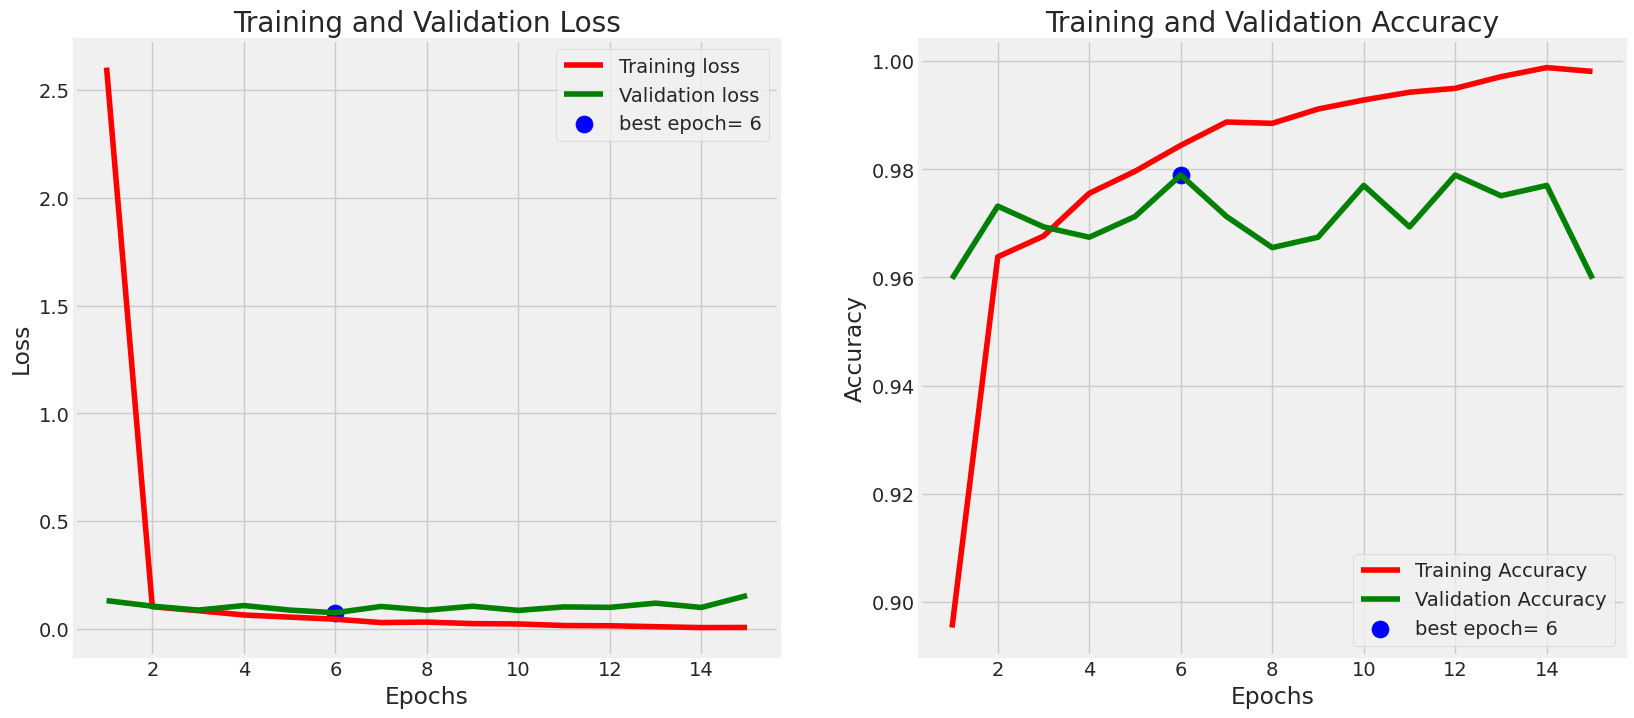

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step


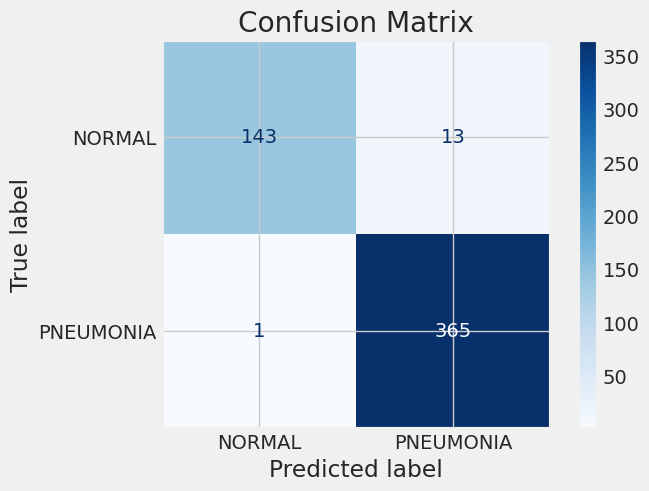

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(test_gen)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_gen.labels

# Retrieve class names dynamically from the generator
classes = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1) 
print(classification_report(test_gen.classes,y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       156
           1       0.97      1.00      0.98       366

    accuracy                           0.97       522
   macro avg       0.98      0.96      0.97       522
weighted avg       0.97      0.97      0.97       522

